In [330]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf # 런타임 재시작 필요

In [331]:

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [332]:
# !pip install optuna

In [333]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [334]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
import optuna

# DATA_PATH = "/content/drive/MyDrive/DACON_DAEGU/data/"
DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/대구 교통사고 피해 예측/data/'
SEED = 42

In [335]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [336]:
import numpy as snp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

In [337]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer, mean_squared_log_error

# DATA Load

In [338]:
train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
accident_df = pd.read_csv(f"{DATA_PATH}countrywide_accident.csv")
DG_cctv = pd.read_csv(f"{DATA_PATH}대구 CCTV 정보.csv", encoding='cp949')
DG_parking = pd.read_csv(f"{DATA_PATH}대구 주차장 정보.csv", encoding='cp949')
DG_children_area = pd.read_csv(f"{DATA_PATH}대구 어린이 보호 구역 정보.csv", encoding='cp949')
DG_seculight = pd.read_csv(f"{DATA_PATH}대구 보안등 정보.csv", encoding='cp949')
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

train_df.shape, test_df.shape, # accident_df.shape, cctv_df.shape, park_df.shape, zone_df.shape, security_df.shape

((39609, 23), (10963, 8))

In [339]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [340]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

# test 데이터 반영
test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [341]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_df['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

# test 데이터 반영
test_df[['도로형태1', '도로형태2']] = test_df['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [342]:
# train_df = pd.read_csv(f'{DATA_PATH}train_df_150_1125.csv')
# test_df = pd.read_csv(f'{DATA_PATH}test_df_150_1125.csv')

train_df.shape, test_df.shape

((39609, 29), (10963, 14))

# Feature 1 : train에만 있는 feature

- 세부분류
- 법규위반
- 가해운전자/피해운전자 차종
- 가해운전자/피해운전자 성별
- 가해운전자/피해운전자 연령

- 피해운전자 상해정도별 -> ECLO는 숫자, 상해정도는 개별, 총 ECLO와의 인과관계 적어서 일단 제거함

In [343]:
train_ft1 = pd.read_csv(f"{DATA_PATH}train.csv")
train_ft1

# 시간
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_ft1[['연', '월', '일', '시간']] = train_ft1['사고일시'].str.extract(time_pattern)
train_ft1[['연', '월', '일', '시간']] = train_ft1[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_ft1 = train_ft1.drop(columns=['사고일시'])

# 시군구
location_pattern = r'(\S+) (\S+) (\S+)'

train_ft1[['도시', '구', '동']] = train_ft1['시군구'].str.extract(location_pattern)
train_ft1 = train_ft1.drop(columns=['시군구'])

# 도로형태

road_pattern = r'(.+) - (.+)'

train_ft1[['도로형태1', '도로형태2']] = train_ft1['도로형태'].str.extract(road_pattern)
train_ft1 = train_ft1.drop(columns=['도로형태'])

In [344]:
basic_cols = train_ft1.iloc[:, list(range(1, 5)) + list(range(20, len(train_ft1.columns)))].columns.tolist()
basic_cols

['요일',
 '기상상태',
 '노면상태',
 '사고유형',
 '연',
 '월',
 '일',
 '시간',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

- 세부분류

In [345]:
df = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['사고유형 - 세부분류'])[['ECLO']].std().reset_index().iloc[:,1:]

# 실험
df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['사고유형 - 세부분류','median','mean','count','sum','min','max','std']
df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
df_acc['max_median'] = df_acc['max'] * df_acc['median']
df_acc['max_std'] = df_acc['max'] * df_acc['std']
df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])

# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['사고유형 - 세부분류'].tolist()

In [346]:
df_cols

['추돌',
 '기타',
 '측면충돌',
 '정면충돌',
 '공작물충돌',
 '횡단중',
 '전도전복 - 전도',
 '후진중충돌',
 '보도통행중',
 '차도통행중',
 '길가장자리구역통행중',
 '전도전복 - 전복',
 '도로외이탈 - 추락',
 '도로외이탈 - 기타']

In [347]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['사고유형 - 세부분류_sorted'] = train_ft1['사고유형 - 세부분류'].map(label_mapping)

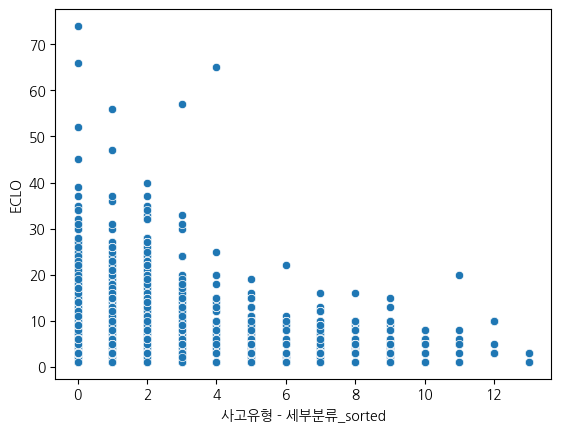

In [348]:
for col in train_ft1[['사고유형 - 세부분류_sorted', '사고유형 - 세부분류']]:
    sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
    break

- 법규위반

In [349]:
train_ft1.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '사고유형 - 세부분류_sorted'],
      dtype='object')

In [350]:
df = train_ft1.groupby(['법규위반'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['법규위반'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['법규위반'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['법규위반'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['법규위반'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['법규위반'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['법규위반'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['법규위반','median','mean','count','sum','min','max','std']
df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
df_acc['max_median'] = df_acc['max'] * df_acc['median']
df_acc['max_std'] = df_acc['max'] * df_acc['std']
df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['법규위반'].tolist()

In [351]:
df_cols

['안전운전불이행',
 '안전거리미확보',
 '신호위반',
 '차로위반',
 '과속',
 '기타',
 '중앙선침범',
 '교차로운행방법위반',
 '보행자보호의무위반',
 '직진우회전진행방해',
 '불법유턴']

In [352]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['법규위반_sorted'] = train_ft1['법규위반'].map(label_mapping)

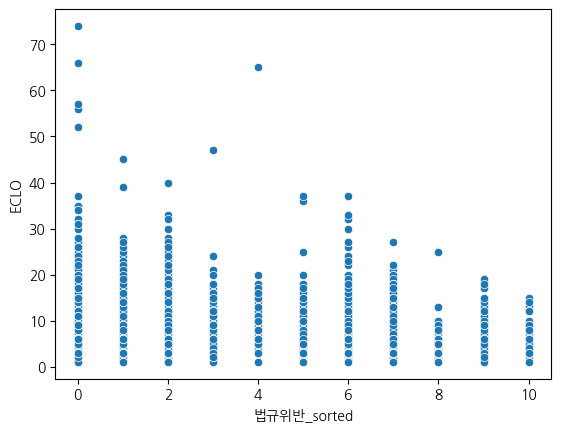

In [353]:
for col in train_ft1[['법규위반_sorted', '법규위반']]:
    sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
    break

- 가해운전자 차종

In [354]:
df = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['가해운전자 차종'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['가해운전자 차종','median','mean','count','sum','min','max','std']
df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
df_acc['max_median'] = df_acc['max'] * df_acc['median']
df_acc['max_std'] = df_acc['max'] * df_acc['std']
df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['가해운전자 차종'].tolist()

In [355]:
df_cols

['승용',
 '화물',
 '승합',
 '이륜',
 '건설기계',
 '원동기',
 '자전거',
 '기타불명',
 '특수',
 '개인형이동수단(PM)',
 '사륜오토바이(ATV)',
 '농기계']

In [356]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['가해운전자 차종_sorted'] = train_ft1['가해운전자 차종'].map(label_mapping)

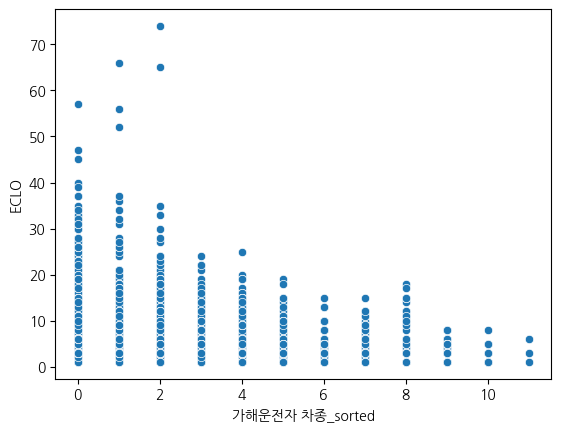

In [357]:
for col in train_ft1[['가해운전자 차종_sorted', '가해운전자 차종']]:
    sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
    break

- 피해운전자 차종

In [358]:
df = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].mean().reset_index()
df0 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].count().reset_index().iloc[:,1:]
df1 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].sum().reset_index().iloc[:,1:]
df2 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].min().reset_index().iloc[:,1:]
df3 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].max().reset_index().iloc[:,1:]
df4 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].median().reset_index().iloc[:,1:]
df5 = train_ft1.groupby(['피해운전자 차종'])[['ECLO']].std().reset_index().iloc[:,1:]


df_acc = pd.concat([df, df4,df0, df1, df2, df3, df5], axis=1)
df_acc.columns = ['가해운전자 차종','median','mean','count','sum','min','max','std']
df_acc['max_mean'] = df_acc['max'] * df_acc['mean']
df_acc['max_median'] = df_acc['max'] * df_acc['median']
df_acc['max_std'] = df_acc['max'] * df_acc['std']
df_acc['mean_median'] = df_acc['mean'] * df_acc['median']
df_acc['max_count'] = df_acc['max'] * (df_acc['count'])
df_acc['max_count_medianmean'] = df_acc['max'] * df_acc['count'] * (df_acc['mean'] + df_acc['median'])/2
df_acc['max_count_log'] = df_acc['max'] * np.log(df_acc['count'])
df_acc['max_count_log_mean'] = df_acc['max'] * np.log(df_acc['count']) *np.log(df_acc['mean'])
df_acc['count_log_median'] = np.log(df_acc['count']) * df_acc['median']
df_acc['max_count_log_median'] = df_acc['max'] * np.log(df_acc['count']) *df_acc['median']


# max count_log의 조합을 기준으로 정렬해서 라벨 인코딩 (비슷한 범주가 라벨링된다는 가정하에 범주를 평균할 수 있으므로)
df_acc = df_acc.sort_values(by='max_count_log', ascending=False)
# display(df_acc)

df_cols = df_acc['가해운전자 차종'].tolist()

In [359]:
df_cols

['승용',
 '승합',
 '화물',
 '보행자',
 '이륜',
 '원동기',
 '자전거',
 '건설기계',
 '특수',
 '개인형이동수단(PM)',
 '농기계',
 '사륜오토바이(ATV)',
 '기타불명']

In [360]:
label_mapping = {label: index for index, label in enumerate(df_cols)}
train_ft1['피해운전자 차종_sorted'] = train_ft1['피해운전자 차종'].map(label_mapping)

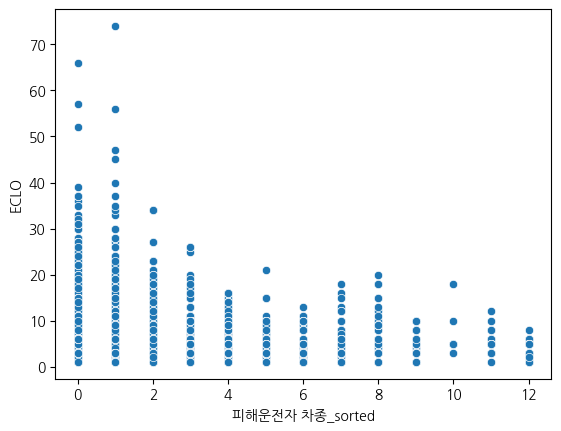

In [361]:
for col in train_ft1[['피해운전자 차종_sorted', '피해운전자 차종']]:
    sns.scatterplot(x=train_ft1[col], y=train_ft1['ECLO'])
    break

- 연령

In [362]:
import re

train_ft1['가해운전자 연령'] = train_ft1['가해운전자 연령'].apply(lambda x: re.sub(r'\D', '', str(x)))
train_ft1['가해운전자 연령_sorted'] = pd.to_numeric(train_ft1['가해운전자 연령'], errors='coerce')

train_ft1['피해운전자 연령'] = train_ft1['피해운전자 연령'].apply(lambda x: re.sub(r'\D', '', str(x)))
train_ft1['피해운전자 연령_sorted'] = pd.to_numeric(train_ft1['피해운전자 연령'], errors='coerce')


- 성별

In [363]:
gender_mapping = {'남': 0, '기타불명': 1, '여': 2}

train_ft1['가해운전자 성별_sorted'] = train_ft1['가해운전자 성별'].map(gender_mapping)
train_ft1['피해운전자 성별_sorted'] = train_ft1['피해운전자 성별'].map(gender_mapping)

train_ft1['가해운전자 성별_sorted'] = pd.to_numeric(train_ft1['가해운전자 성별_sorted'], errors='coerce')
train_ft1['피해운전자 성별_sorted'] = pd.to_numeric(train_ft1['피해운전자 성별_sorted'], errors='coerce')

In [364]:
feature_1 = ['사고유형 - 세부분류_sorted', '법규위반_sorted',
             '가해운전자 차종_sorted', '피해운전자 차종_sorted',
             '가해운전자 연령_sorted', '피해운전자 연령_sorted',
             '가해운전자 성별_sorted', '피해운전자 성별_sorted']

- 시간대

In [365]:
def categorize_time_period(hour):
    if 6 <= hour < 9:  # 아침 출퇴근 시간
        return 0
    elif 9 <= hour < 12:  # 아침
        return 1
    elif 12 <= hour < 14:  # 점심
        return 2
    elif 14 <= hour < 18:  # 오후
        return 3
    elif 18 <= hour < 21:  # 저녁
        return 4
    elif 21 <= hour < 24:  # 밤
        return 5
    else:  # 새벽
        return 6

train_ft1['시간대'] = train_ft1['시간'].apply(categorize_time_period)

train_df['시간대'] = train_df['시간'].apply(categorize_time_period)
test_df['시간대'] = test_df['시간'].apply(categorize_time_period)

In [366]:
abs(train_ft1.corr()['ECLO']).sort_values(ascending=False)

ECLO                  1.000000
경상자수                  0.636370
중상자수                  0.464520
사망자수                  0.218507
피해운전자 차종_sorted       0.181512
가해운전자 차종_sorted       0.137658
부상자수                  0.118713
사고유형 - 세부분류_sorted    0.090990
시간대                   0.036769
연                     0.031281
피해운전자 연령_sorted       0.031139
법규위반_sorted           0.028632
피해운전자 성별_sorted       0.025193
시간                    0.017355
일                     0.012303
가해운전자 연령_sorted       0.008411
월                     0.006871
가해운전자 성별_sorted       0.006795
Name: ECLO, dtype: float64

In [367]:
feature1_merge_df = train_ft1.groupby(['구','요일','시간대','사고유형','기상상태','도로형태2'])[feature_1].mean().reset_index()

In [368]:
train_df = pd.merge(train_df,feature1_merge_df, on = ['구','요일','시간대','사고유형','기상상태','도로형태2'], how='left' )
test_df = pd.merge(test_df,feature1_merge_df, on = ['구','요일','시간대','사고유형','기상상태','도로형태2'], how='left' )

In [369]:
train_df.columns

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '시간대',
       '사고유형 - 세부분류_sorted', '법규위반_sorted', '가해운전자 차종_sorted',
       '피해운전자 차종_sorted', '가해운전자 연령_sorted', '피해운전자 연령_sorted',
       '가해운전자 성별_sorted', '피해운전자 성별_sorted'],
      dtype='object')

  0%|          | 0/37 [00:00<?, ?it/s]

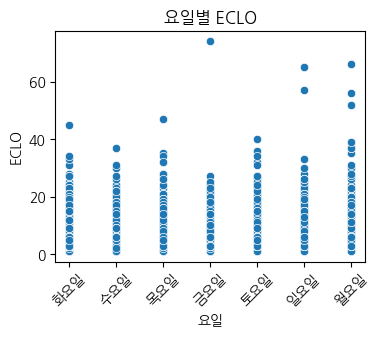

  3%|▎         | 1/37 [00:00<00:13,  2.67it/s]

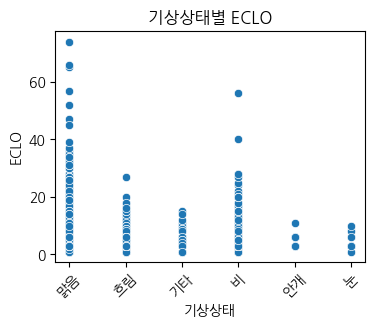

  5%|▌         | 2/37 [00:00<00:12,  2.78it/s]

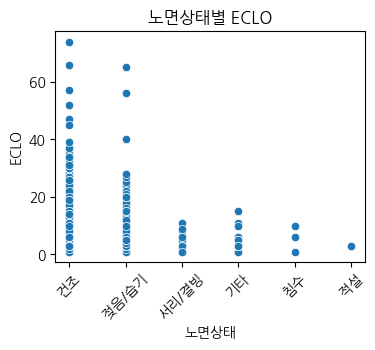

  8%|▊         | 3/37 [00:01<00:15,  2.27it/s]

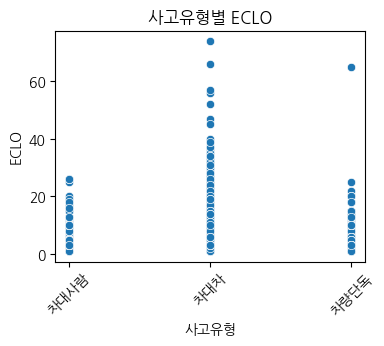

 11%|█         | 4/37 [00:01<00:15,  2.09it/s]

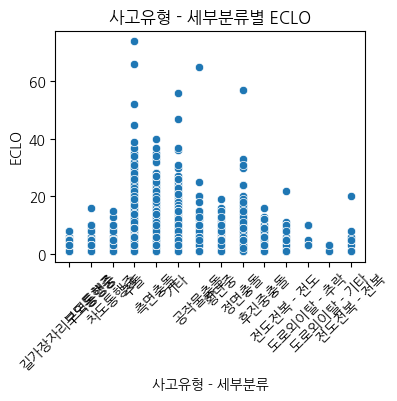

 14%|█▎        | 5/37 [00:02<00:14,  2.26it/s]

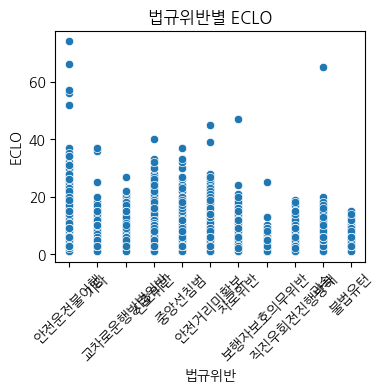

 16%|█▌        | 6/37 [00:02<00:13,  2.36it/s]

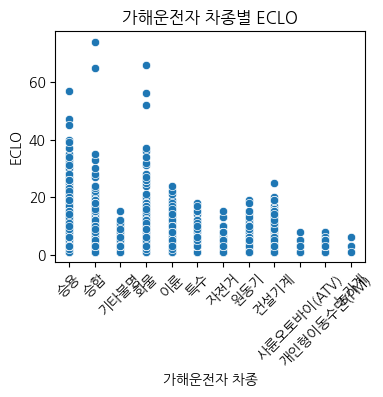

 19%|█▉        | 7/37 [00:02<00:12,  2.47it/s]

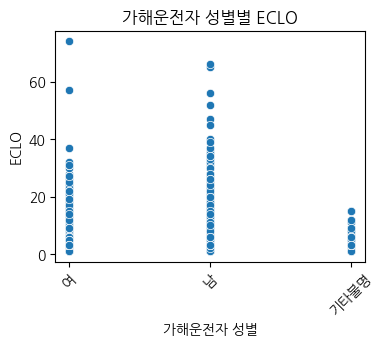

 22%|██▏       | 8/37 [00:03<00:10,  2.66it/s]

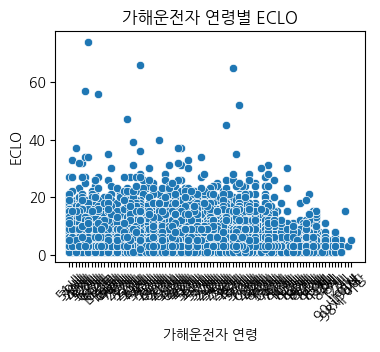

 24%|██▍       | 9/37 [00:04<00:14,  1.99it/s]

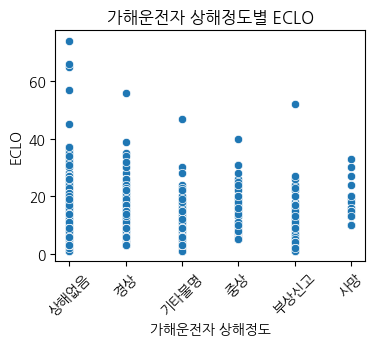

 27%|██▋       | 10/37 [00:04<00:12,  2.19it/s]

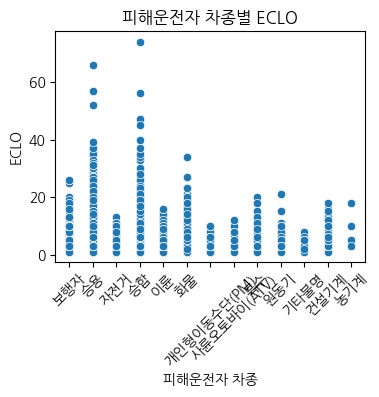

 30%|██▉       | 11/37 [00:04<00:11,  2.33it/s]

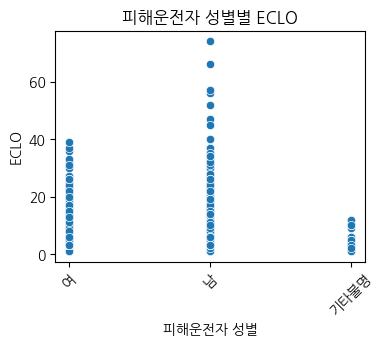

 32%|███▏      | 12/37 [00:05<00:10,  2.49it/s]

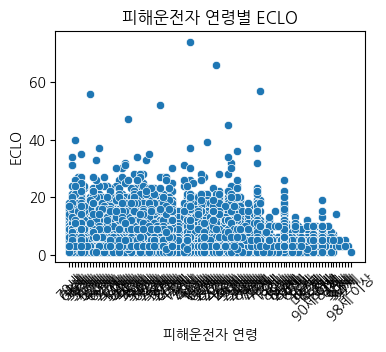

 35%|███▌      | 13/37 [00:05<00:12,  1.89it/s]

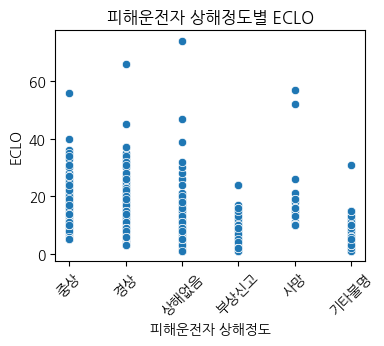

 38%|███▊      | 14/37 [00:06<00:10,  2.13it/s]

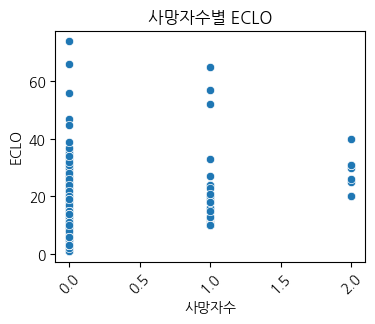

 41%|████      | 15/37 [00:06<00:09,  2.34it/s]

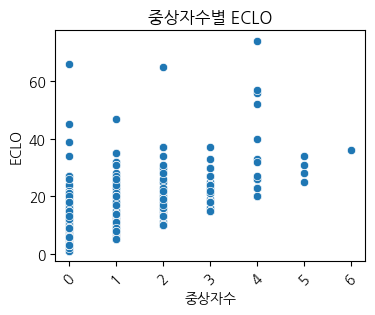

 43%|████▎     | 16/37 [00:06<00:08,  2.55it/s]

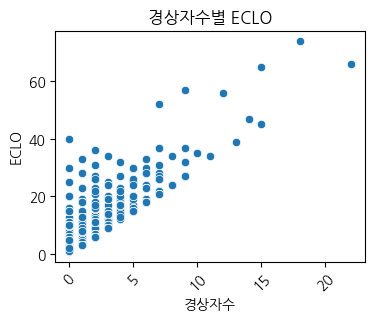

 46%|████▌     | 17/37 [00:07<00:07,  2.70it/s]

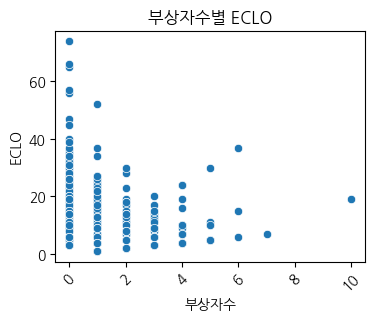

 49%|████▊     | 18/37 [00:07<00:06,  2.81it/s]

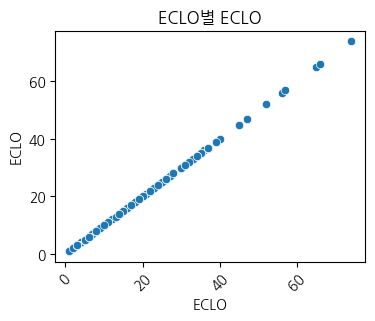

 51%|█████▏    | 19/37 [00:07<00:06,  2.94it/s]

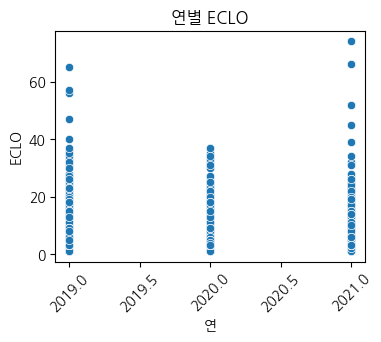

 54%|█████▍    | 20/37 [00:08<00:05,  2.96it/s]

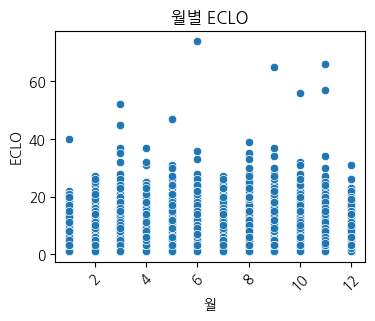

 57%|█████▋    | 21/37 [00:08<00:05,  2.96it/s]

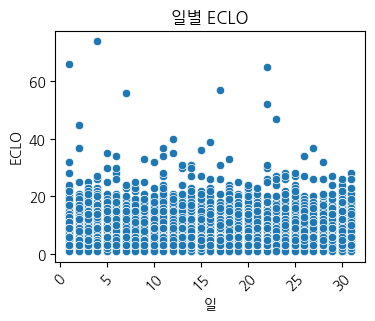

 59%|█████▉    | 22/37 [00:08<00:04,  3.01it/s]

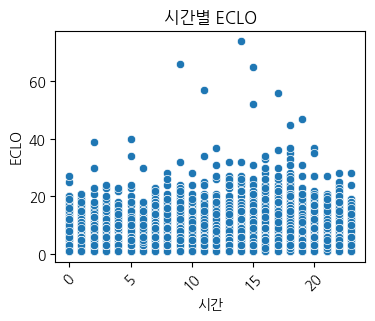

 62%|██████▏   | 23/37 [00:09<00:04,  3.06it/s]

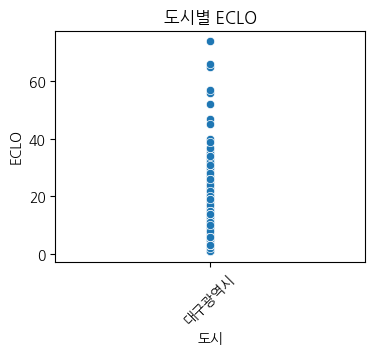

 65%|██████▍   | 24/37 [00:09<00:04,  3.08it/s]

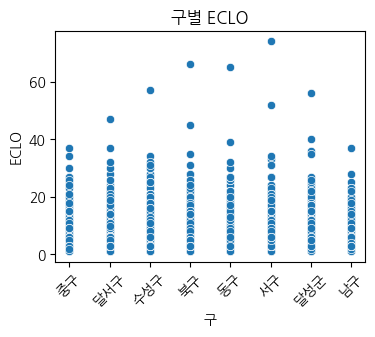

 68%|██████▊   | 25/37 [00:09<00:04,  2.68it/s]

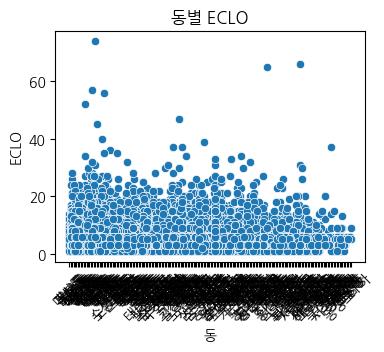

 70%|███████   | 26/37 [00:12<00:10,  1.01it/s]

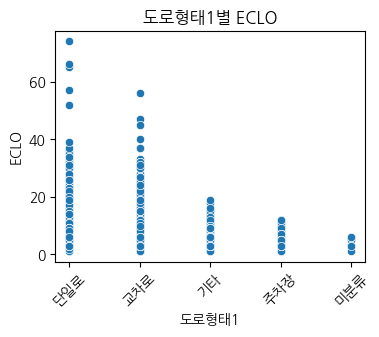

 73%|███████▎  | 27/37 [00:12<00:08,  1.17it/s]

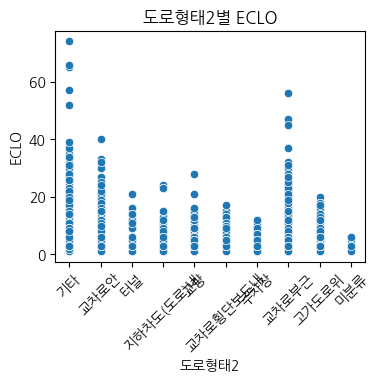

 76%|███████▌  | 28/37 [00:13<00:06,  1.29it/s]

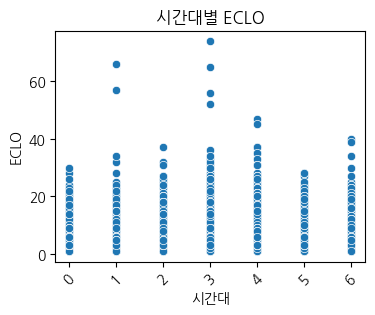

 78%|███████▊  | 29/37 [00:13<00:05,  1.44it/s]

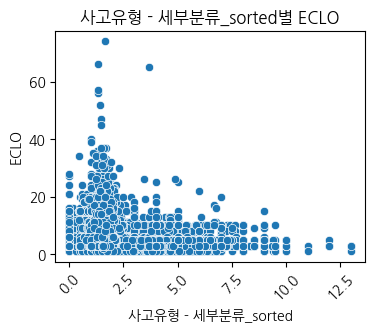

 81%|████████  | 30/37 [00:14<00:04,  1.59it/s]

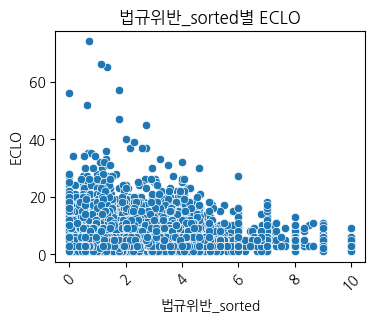

 84%|████████▍ | 31/37 [00:14<00:03,  1.70it/s]

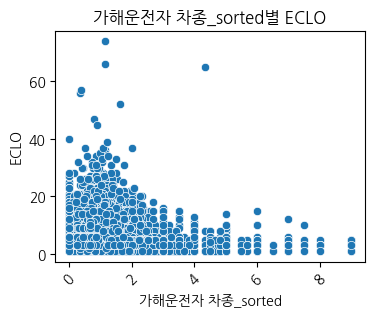

 86%|████████▋ | 32/37 [00:15<00:02,  1.80it/s]

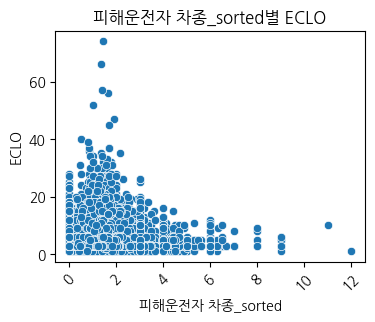

 89%|████████▉ | 33/37 [00:15<00:02,  1.90it/s]

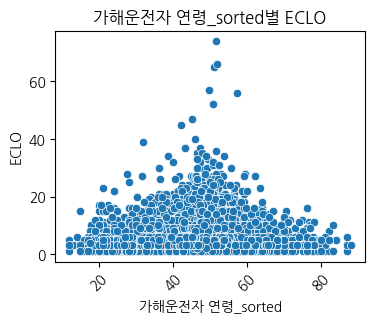

 92%|█████████▏| 34/37 [00:16<00:01,  2.04it/s]

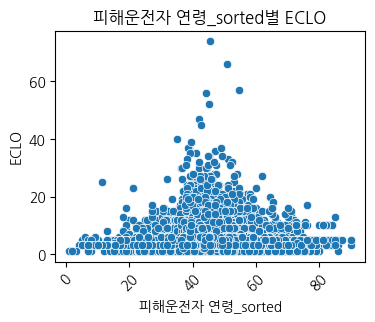

 95%|█████████▍| 35/37 [00:16<00:00,  2.07it/s]

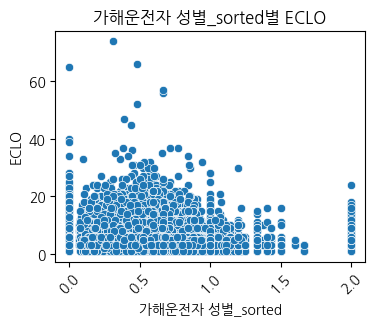

 97%|█████████▋| 36/37 [00:17<00:00,  2.07it/s]

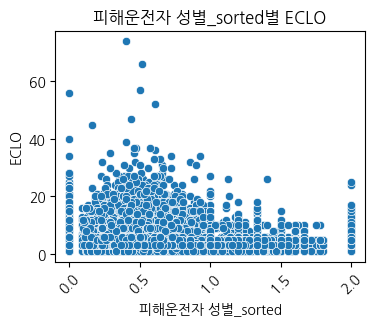

100%|██████████| 37/37 [00:17<00:00,  2.09it/s]


In [370]:
from tqdm import tqdm

for col in tqdm(train_df.columns[-7:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

# Feature 2 : cctv/ 주차장/ 보호구역 등

In [371]:
df = train_df[['도시','구','동']]

df1 = pd.get_dummies(train_df['요일'], prefix = '요일')
df2 = pd.get_dummies(train_df['연'], prefix = '연')
df3 = pd.get_dummies(train_df['월'], prefix = '월')
# df4 = pd.get_dummies(train_df['일'], prefix = '일')
# df5 = pd.get_dummies(train_df['시간'], prefix = '시간')


df6 = pd.get_dummies(train_df['기상상태'], prefix = '기상상태')
df7 = pd.get_dummies(train_df['노면상태'], prefix = '노면상태')
df8 = pd.get_dummies(train_df['도로형태1'], prefix = '도로형태1')
df9 = pd.get_dummies(train_df['도로형태2'], prefix = '도로형태2')
df10 = pd.get_dummies(train_df['사고유형'], prefix = '사고유형')

train_time_merge= pd.concat([df, df1, df2, df3, df6,df7,df8, df9, df10], axis=1) #23개 열

In [372]:
train_time_merge_df = train_time_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(train_time_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(train_time_merge_df, on = ['도시','구','동'], how='left')

In [373]:
train_df['노면상태'].value_counts()

건조       36420
젖음/습기     3100
기타          58
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64

In [374]:
test_df['노면상태'].value_counts()

건조       10394
젖음/습기      524
기타          35
서리/결빙        7
침수           2
적설           1
Name: 노면상태, dtype: int64

## 보안등

In [375]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_seculight[['도시', '구', '동','번지']] = DG_seculight['소재지지번주소'].str.extract(location_pattern)
DG_seculight = DG_seculight.drop(columns=['소재지지번주소'])

In [376]:
df1 = DG_seculight.groupby(['도시','구','동'])[['설치개수']].sum().reset_index()
df1.columns = ['도시','구','동','보안등_설치개수']

df2 = pd.get_dummies(DG_seculight['설치형태'], prefix='보안등')
df2 = pd.concat([DG_seculight[['도시','구','동']], df2], axis=1)
df2 = df2.groupby(['도시','구','동']).sum().reset_index().drop(columns =['도시','구','동'])

seculight_merge = pd.concat([df1, df2], axis=1)

train_df = pd.merge(train_df,seculight_merge, on = ['도시','구','동'], how='left')
test_df = pd.merge(test_df,seculight_merge, on = ['도시','구','동'], how='left')

## cctv

In [377]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_cctv[['도시', '구', '동','번지']] = DG_cctv['소재지지번주소'].str.extract(location_pattern)
DG_cctv = DG_cctv.drop(columns=['소재지지번주소'])

In [378]:
df = DG_cctv[['도시','구','동']]
df['cctv_설치개수'] = 1

df1 = pd.get_dummies(DG_cctv['보호구역구분'], prefix = '보호구역구분')
df2 = pd.get_dummies(DG_cctv['단속구분'], prefix = '단속구분')
df3 = pd.get_dummies(DG_cctv['도로종류'], prefix = '도로종류')
df4 = pd.get_dummies(DG_cctv['제한속도'], prefix = '제한속도')

cctv_merge= pd.concat([df, df1, df2, df3, df4], axis=1) #23개 열

cctv_merge_df = cctv_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(cctv_merge_df, on = ['도시','구','동'], how='left')

## 어린이 보호

In [379]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_children_area[['도시', '구', '동','번지']] = DG_children_area['소재지지번주소'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['소재지지번주소'])

In [380]:
location_pattern = r'(\S+)~(\S+)'

DG_children_area[['보호구역도로폭_min', '보호구역도로폭_max']] = DG_children_area['보호구역도로폭'].str.extract(location_pattern)
DG_children_area = DG_children_area.drop(columns=['보호구역도로폭'])

In [381]:
DG_children_area['보호구역도로폭_min'] = DG_children_area['보호구역도로폭_min'].astype(float)
DG_children_area['보호구역도로폭_max'] = DG_children_area['보호구역도로폭_max'].astype(float)

In [382]:
# 범주형 - 동별 onehot 인코딩 합계로 cctv처리

df = DG_children_area[['도시','구','동']]

df1 = pd.get_dummies(DG_children_area['시설종류'], prefix = '시설종류')

children_area_merge= pd.concat([df, df1], axis=1)
children_area_merge #23개 열

children_area_merge_df = children_area_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(children_area_merge_df, on = ['도시','구','동'], how='left')

In [383]:
df2 = DG_children_area.groupby(['도시','구','동'])[['CCTV설치대수']].mean().reset_index()
df3 = DG_children_area.groupby(['도시','구','동'])[['보호구역도로폭_min']].max().reset_index()
df4 = DG_children_area.groupby(['도시','구','동'])[['보호구역도로폭_max']].max().reset_index()

In [384]:
train_df = train_df.merge(df2, on = ['도시','구','동'], how='left')
test_df = test_df.merge(df2, on = ['도시','구','동'], how='left')

train_df = train_df.merge(df3, on = ['도시','구','동'], how='left')
test_df = test_df.merge(df3, on = ['도시','구','동'], how='left')

train_df = train_df.merge(df4, on = ['도시','구','동'], how='left')
test_df = test_df.merge(df4, on = ['도시','구','동'], how='left')

## 주차장

In [385]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

DG_parking[['도시', '구', '동','번지']] = DG_parking['소재지지번주소'].str.extract(location_pattern)
DG_parking = DG_parking.drop(columns=['소재지지번주소'])

In [386]:
df = DG_parking[['도시','구','동']]

df1 = pd.get_dummies(DG_parking['주차장구분'], prefix = '주차장구분')
df2 = pd.get_dummies(DG_parking['주차장유형'], prefix = '주차장유형')
df3 = pd.get_dummies(DG_parking['급지구분'], prefix = '급지구분')
df4 = pd.get_dummies(DG_parking['부제시행구분'], prefix = '부제시행구분')
df5 = pd.get_dummies(DG_parking['운영요일'], prefix = '운영요일')
df6 = pd.get_dummies(DG_parking['요금정보'], prefix = '요금정보')
df7 = pd.get_dummies(DG_parking['결제방법'], prefix = '결제방법')


parking_merge= pd.concat([df, df1, df2, df3, df4, df5, df6, df7], axis=1)

parking_merge_df = parking_merge.groupby(['도시','구','동']).sum().reset_index()

train_df = train_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_merge_df, on = ['도시','구','동'], how='left')


In [387]:
parking_num_cols = ['도시','구','동','주차구획수', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각','주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금' ]

df = DG_parking[parking_num_cols]

from datetime import datetime

def time_to_int(time_str):
#     time_str = time
    time_obj = datetime.strptime(time_str, "%H:%M")
    # 시간을 분 단위로 변환하고 24로 나누어 표현
    hours_decimal = (time_obj.hour * 60 + time_obj.minute) / 60.0
    return hours_decimal

df['평일운영시작시각'] = df['평일운영시작시각'].apply(time_to_int)
df['평일운영종료시각'] = df['평일운영종료시각'].apply(time_to_int)
df['토요일운영시작시각'] = df['토요일운영시작시각'].apply(time_to_int)
df['토요일운영종료시각'] = df['토요일운영종료시각'].apply(time_to_int)
df['공휴일운영시작시각'] = df['공휴일운영시작시각'].apply(time_to_int)
df['공휴일운영종료시각'] = df['공휴일운영종료시각'].apply(time_to_int)

parking_num_merge_df = df.groupby(['도시','구','동']).mean().reset_index()

train_df = train_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')
test_df = test_df.merge(parking_num_merge_df, on = ['도시','구','동'], how='left')


In [388]:
from tqdm import tqdm

for col in tqdm(train_df.columns[1:]) :
    plt.figure(figsize= (4,3))
    sns.scatterplot(x=train_df[col], y=train_df.ECLO)
    plt.title(f'{col}별 ECLO')
    plt.xticks(rotation=45)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [389]:
feature_2 = [
 'ID',
 '요일',

 '기상상태',
 '노면상태',
 '사고유형',

 '연',
 '월',
 '시간',

 '구',
 '동',
 '도로형태1',
 '도로형태2',

 '기상상태_기타',
 '기상상태_눈',
 '기상상태_안개',
 '기상상태_흐림',

 '노면상태_기타',
 '노면상태_서리/결빙',
 '노면상태_적설',
 '노면상태_침수',

 '도로형태1_기타',
 '도로형태1_미분류',
 '도로형태1_주차장',

 '도로형태2_고가도로위',
 '도로형태2_교량',
 '도로형태2_미분류',
 '도로형태2_주차장',
 '도로형태2_지하차도(도로)내',
 '도로형태2_터널',

 '보안등_건축물',
 '보안등_전용주',
 '보안등_한전주',
 'cctv_설치개수',

 '보호구역구분_1.0',
 '보호구역구분_2.0',

 '단속구분_1',
 '단속구분_4',
 '단속구분_99',

 '도로종류_고속국도',
 '도로종류_구도',
 '도로종류_시도',
 '도로종류_일반국도',
 '도로종류_지방도',

 '제한속도_0',
 '제한속도_30',
 '제한속도_40',
 '제한속도_60',
 '제한속도_70',
 '제한속도_80',
 '제한속도_100',

 '시설종류_어린이집',
 '시설종류_초등학교',
 '시설종류_특수학교',
 '시설종류_학원',

 'CCTV설치대수',
 '보호구역도로폭_min',
 '보호구역도로폭_max',

 '주차장구분_민영',
 '주차장유형_노외',

 '급지구분_1',
 '급지구분_3',

 '운영요일_평일',
 '운영요일_평일+토요일',

 '요금정보_무료',
 '요금정보_유료',
 '요금정보_혼합',

 '결제방법_무료',
 '결제방법_신용카드',
 '결제방법_카드',
 '결제방법_현금',
 '결제방법_현금,카드',

 '주차구획수',
 '공휴일운영시작시각',
 '주차기본시간',
 '주차기본요금',

]


In [390]:
test_df[feature_2]

,ID,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,...,요금정보_혼합,결제방법_무료,결제방법_신용카드,결제방법_카드,결제방법_현금,"결제방법_현금,카드",주차구획수,공휴일운영시작시각,주차기본시간,주차기본요금
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,수성구,상동,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,수성구,지산동,...,2.0,0.0,0.0,1.0,0.0,1.0,91.500000,4.000000,75.000000,700.000000
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,4,수성구,수성동2가,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,4,수성구,신매동,...,3.0,0.0,0.0,2.0,0.0,1.0,51.000000,0.000000,30.000000,333.333333
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,6,달서구,감삼동,...,0.0,0.0,0.0,0.0,2.0,0.0,28.500000,4.500000,735.000000,150.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,18,남구,대명동,...,0.0,0.0,0.0,0.0,13.0,0.0,33.761905,2.142857,18.571429,204.761905
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,18,수성구,시지동,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,20,수성구,연호동,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,20,수성구,범물동,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
train_df.shape, test_df.shape

((39609, 163), (10963, 148))

In [392]:
test_x = test_df[feature_2+feature_1].drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()

train_y = train_df['ECLO'].copy()

test_x.shape, train_x.shape, train_y.shape

((10963, 82), (39609, 82), (39609,))

# Encoding

In [393]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Columns: 163 entries, ID to 월정기권요금
dtypes: float64(81), int64(10), object(20), uint64(40), uint8(12)
memory usage: 46.4+ MB


In [394]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   요일                  39609 non-null  object 
 1   기상상태                39609 non-null  object 
 2   노면상태                39609 non-null  object 
 3   사고유형                39609 non-null  object 
 4   연                   39609 non-null  int64  
 5   월                   39609 non-null  int64  
 6   시간                  39609 non-null  int64  
 7   구                   39609 non-null  object 
 8   동                   39609 non-null  object 
 9   도로형태1               39609 non-null  object 
 10  도로형태2               39609 non-null  object 
 11  기상상태_기타             39609 non-null  uint64 
 12  기상상태_눈              39609 non-null  uint64 
 13  기상상태_안개             39609 non-null  uint64 
 14  기상상태_흐림             39609 non-null  uint64 
 15  노면상태_기타             39609 non-null  uint64 
 16  노면상태

In [395]:
from sklearn.preprocessing import LabelEncoder
# from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

['요일', '기상상태', '노면상태', '사고유형', '구', '동', '도로형태1', '도로형태2']

In [396]:
for col in categorical_features:
    enc = LabelEncoder()
    train_x[col]=enc.fit_transform(train_x[col])
    test_x[col]=enc.transform(test_x[col])

train_x.head()

,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,도로형태1,...,주차기본시간,주차기본요금,사고유형 - 세부분류_sorted,법규위반_sorted,가해운전자 차종_sorted,피해운전자 차종_sorted,가해운전자 연령_sorted,피해운전자 연령_sorted,가해운전자 성별_sorted,피해운전자 성별_sorted
0,6,2,0,0,2019,1,0,7,40,2,...,32.727273,1136.363636,5.333333,0.000000,0.500000,3.000000,26.666667,31.000000,1.000000,1.000000
1,6,5,0,0,2019,1,0,1,4,2,...,735.000000,150.000000,8.000000,5.000000,0.000000,3.000000,39.000000,61.000000,0.000000,0.000000
2,6,2,0,0,2019,1,1,6,66,2,...,NaN,NaN,4.666667,0.555556,1.000000,3.000000,43.750000,37.666667,0.111111,0.222222
3,6,2,0,1,2019,1,2,4,79,2,...,2.142857,71.428571,1.500000,1.000000,0.285714,1.071429,44.357143,52.928571,0.142857,0.428571
4,6,2,0,1,2019,1,4,3,129,2,...,30.000000,600.000000,0.950000,0.550000,0.900000,0.800000,40.052632,42.450000,0.350000,0.200000


In [397]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

# 학습 및 검증

In [398]:
target = np.log1p(train_y)
target

0        1.791759
1        1.386294
2        1.386294
3        1.791759
4        1.386294
           ...   
39604    1.386294
39605    1.386294
39606    2.397895
39607    1.386294
39608    1.945910
Name: ECLO, Length: 39609, dtype: float64

In [399]:
def rmsle(y_valid, pred):
    msle = mean_squared_log_error(y_valid, pred)
    return np.sqrt(msle)

rmsle_score = make_scorer(rmsle, greater_is_better=False)

## DL

In [400]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [401]:
callbacks_list = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

# print(train_x.shape, train_y.shape)
# print(train_x.isnull().sum().sum(), train_y.isnull().sum().sum())

In [402]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [403]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

In [405]:
model = create_model()
history = model.fit(train_x.astype('float32'),target.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1114/1114 [==============================] - 6s 3ms/step - loss: 0.1921 - metric_fn: 0.1921 - val_loss: 0.1671 - val_metric_fn: 0.1671 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 8s 7ms/step - loss: 0.1735 - metric_fn: 0.1735 - val_loss: 0.1647 - val_metric_fn: 0.1647 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 4s 4ms/step - loss: 0.1718 - metric_fn: 0.1718 - val_loss: 0.1630 - val_metric_fn: 0.1630 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1707 - metric_fn: 0.1707 - val_loss: 0.1625 - val_metric_fn: 0.1625 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 3s 3ms/step - loss: 0.1701 - metric_fn: 0.1701 - val_loss: 0.1626 - val_metric_fn: 0.1625 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 4s 4ms/step - loss: 0.1700 - metric_fn: 0.1700 - val_loss: 0.1623 - val_metric_fn: 0.1623 - lr: 0.0010
Epoch 7/100
1114/1114 [=================

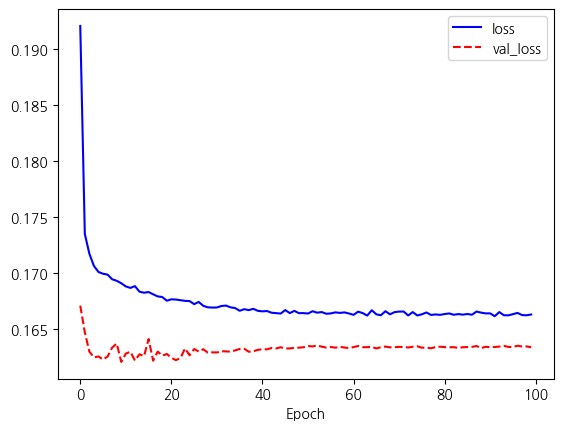

In [406]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [407]:
dl_predict =  model.predict(test_x.astype('float32'))
dl_predict = np.expm1(dl_predict)

submission['ECLO'] = dl_predict
submission

343/343 [==============================] - 1s 3ms/step


,ID,ECLO
0,ACCIDENT_39609,6.297537
1,ACCIDENT_39610,3.353020
2,ACCIDENT_39611,5.020399
3,ACCIDENT_39612,4.407524
4,ACCIDENT_39613,4.687903
...,...,...
10958,ACCIDENT_50567,4.572839
10959,ACCIDENT_50568,4.358106
10960,ACCIDENT_50569,4.373933
10961,ACCIDENT_50570,4.297366


In [408]:
submission.to_csv('feature_exp_v9*_1127_dl.csv', index=False)
submission.to_csv(f'{DATA_PATH}feature_exp_v9*_1127_dl.csv', index=False)

## XGB

In [409]:
def xgb_objective(trial):
    params = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = XGBRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [410]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(xgb_objective, n_trials=100)

[I 2023-11-27 12:46:26,306] A new study created in memory with name: no-name-46392dae-2c90-499c-bd4c-18869d6915a3
[I 2023-11-27 12:46:35,556] Trial 0 finished with value: -0.17201411770329736 and parameters: {'n_estimators': 118, 'max_depth': 48, 'learning_rate': 0.07587945476302646, 'gamma': 0.5986584841970366, 'min_child_weight': 2, 'subsample': 0.2403950683025824, 'colsample_bytree': 0.15227525095137953, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: -0.17201411770329736.
[I 2023-11-27 12:46:44,486] Trial 1 finished with value: -0.17133621536287819 and parameters: {'n_estimators': 216, 'max_depth': 3, 'learning_rate': 0.0972918866945795, 'gamma': 0.8324426408004217, 'min_child_weight': 3, 'subsample': 0.26364247048639056, 'colsample_bytree': 0.2650640588680905, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 1 with value: -0.17133621536287819.
[I 2023-11-27 12:46:52,714] Trial 2 finished with value: -0.1

- -0.1704821289593484 -> -0.17046108602566407

In [411]:
xgb_params = study.best_params
xgb_params

{'n_estimators': 294,
 'max_depth': 21,
 'learning_rate': 0.042647916278716,
 'gamma': 0.022814172552307395,
 'min_child_weight': 6,
 'subsample': 0.597043109697714,
 'colsample_bytree': 0.7581021769151088,
 'reg_alpha': 4.351965296864749,
 'reg_lambda': 1.088931874034452}

In [412]:
xgb_model = XGBRegressor(**xgb_params, random_state=SEED)
xgb_model.fit(train_x, target)
xgb_pred = xgb_model.predict(test_x)
xgb_pred = np.expm1(xgb_pred) # log 역 변환
xgb_pred

array([4.2062845, 3.7571425, 3.6906602, ..., 3.670129 , 3.5646977,
       4.157172 ], dtype=float32)

In [413]:
xgb_sub = submission.copy()
xgb_sub['ECLO'] = xgb_pred
xgb_sub

,ID,ECLO
0,ACCIDENT_39609,4.206285
1,ACCIDENT_39610,3.757143
2,ACCIDENT_39611,3.690660
3,ACCIDENT_39612,4.212839
4,ACCIDENT_39613,3.779696
...,...,...
10958,ACCIDENT_50567,4.009621
10959,ACCIDENT_50568,3.720566
10960,ACCIDENT_50569,3.670129
10961,ACCIDENT_50570,3.564698


In [414]:
xgb_sub.to_csv(f"{DATA_PATH}feature_exp_v9*_1127_xgb.csv", index=False)
xgb_sub.to_csv("feature_exp_v9*_1127_xgb.csv", index=False)

## LGBM

In [415]:
# from sklearn.preprocessing import StandardScaler

# train_lgbm = train_x.copy()
# test_lgbm = test_x.copy()

# # Assuming X is your feature matrix
# scaler = StandardScaler()
# train_lgbm = scaler.fit_transform(train_lgbm)
# test_lgbm = scaler.fit_transform(test_lgbm)


In [416]:
import re
train_x = train_x.rename(columns = lambda x:re.sub('[^가-힣A-Za-z0-9_]+', '', x))
test_x = test_x.rename(columns = lambda x:re.sub('[^가-힣A-Za-z0-9_]+', '', x))

In [417]:
def lgbm_objective(trial):
    params = {
        "verbosity": 1,
        'objective': 'regression',
        # 'boosting_type': 'gbdt',
        'eval_metric': 'rmsle',
        'n_estimators': trial.suggest_int('n_estimators', 10, 400),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': -1,
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = LGBMRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [418]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(lgbm_objective, n_trials=100)

[I 2023-11-27 13:13:19,094] A new study created in memory with name: no-name-0bcc9d59-6e95-4421-b649-de363b8905e9
[I 2023-11-27 13:13:37,681] Trial 0 finished with value: -0.1736657913219141 and parameters: {'n_estimators': 156, 'num_leaves': 244, 'max_depth': 38, 'learning_rate': 0.06026718993550663, 'feature_fraction': 0.24041677639819287, 'bagging_fraction': 0.2403950683025824, 'lambda_l1': 0.5808361216819946, 'lambda_l2': 8.661761457749352, 'min_child_samples': 62}. Best is trial 0 with value: -0.1736657913219141.
[I 2023-11-27 13:13:50,656] Trial 1 finished with value: -0.17011658182087225 and parameters: {'n_estimators': 286, 'num_leaves': 7, 'max_depth': 49, 'learning_rate': 0.08341182143924175, 'feature_fraction': 0.29110519961044856, 'bagging_fraction': 0.26364247048639056, 'lambda_l1': 1.8340450985343382, 'lambda_l2': 3.0424224295953772, 'min_child_samples': 55}. Best is trial 1 with value: -0.17011658182087225.
[I 2023-11-27 13:14:03,449] Trial 2 finished with value: -0.1704

- -0.17093993543240787 -> -0.17092023294612774
- lgbm2 : -0.17095695720697088.
- lgbm3 : -0.170918

In [419]:
lgbm_params = study.best_params
lgbm_params

#trial 1 :
#  {'n_estimators': 287,
#  'depth': 5,
#  'learning_rate': 0.05724317896557044,
#  'l2_leaf_reg': 3.1969295596416476}


{'n_estimators': 400,
 'num_leaves': 228,
 'max_depth': 4,
 'learning_rate': 0.028664536809354962,
 'feature_fraction': 0.23833065775252044,
 'bagging_fraction': 0.34041608907370446,
 'lambda_l1': 7.8190498778346145,
 'lambda_l2': 9.740759614083519,
 'min_child_samples': 26}

In [420]:
lgbm_model = LGBMRegressor(**lgbm_params, random_state=SEED)
lgbm_model.fit(train_x, target)
lgbm_pred = lgbm_model.predict(test_x)
lgbm_pred = np.expm1(lgbm_pred) # log 역 변환
lgbm_pred

[LightGBM] [Warning] feature_fraction is set=0.23833065775252044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23833065775252044
[LightGBM] [Warning] lambda_l2 is set=9.740759614083519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.740759614083519
[LightGBM] [Warning] lambda_l1 is set=7.8190498778346145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8190498778346145
[LightGBM] [Warning] bagging_fraction is set=0.34041608907370446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34041608907370446
[LightGBM] [Warning] feature_fraction is set=0.23833065775252044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23833065775252044
[LightGBM] [Warning] lambda_l2 is set=9.740759614083519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.740759614083519
[LightGBM] [Warning] lambda_l1 is set=7.8190498778346145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.8190498778346145
[LightGBM

array([4.42979432, 3.56113442, 5.53261863, ..., 4.55766282, 4.60075022,
       4.44700007])

In [421]:
lgbm_sub = submission.copy()
lgbm_sub['ECLO'] = lgbm_pred
lgbm_sub

,ID,ECLO
0,ACCIDENT_39609,4.429794
1,ACCIDENT_39610,3.561134
2,ACCIDENT_39611,5.532619
3,ACCIDENT_39612,4.889910
4,ACCIDENT_39613,4.619729
...,...,...
10958,ACCIDENT_50567,4.002013
10959,ACCIDENT_50568,4.494991
10960,ACCIDENT_50569,4.557663
10961,ACCIDENT_50570,4.600750


In [422]:
lgbm_sub.to_csv(f"{DATA_PATH}feature_exp_v9*_1127_lgbm.csv", index=False)
lgbm_sub.to_csv("feature_exp_v9*_1127_lgbm.csv", index=False)

## CAT

In [423]:
!pip install catboost
from catboost import CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.9 MB/s eta 0:00:00


In [424]:
# CatBoostRegressor
def cat_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 400),
        'depth': trial.suggest_int('depth', 1, 16), # 최대 16
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10)
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    model = CatBoostRegressor(**params, random_state=SEED)
    scores = cross_val_score(model, train_x, target, cv=cv, scoring=rmsle_score, n_jobs=-1)

    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(cat_objective, n_trials=100)

[I 2023-11-27 13:46:53,129] A new study created in memory with name: no-name-5363c5cb-24e5-411a-909b-b7e2dfb51736
[I 2023-11-27 14:49:12,388] Trial 0 finished with value: -0.1754683563579908 and parameters: {'n_estimators': 156, 'depth': 16, 'learning_rate': 0.07346740023932911, 'l2_leaf_reg': 5.986584841970366}. Best is trial 0 with value: -0.1754683563579908.
[I 2023-11-27 14:49:17,038] Trial 1 finished with value: -0.1726394978259232 and parameters: {'n_estimators': 71, 'depth': 3, 'learning_rate': 0.006750277604651747, 'l2_leaf_reg': 8.661761457749352}. Best is trial 1 with value: -0.1726394978259232.
[I 2023-11-27 14:54:12,778] Trial 2 finished with value: -0.17209387916345847 and parameters: {'n_estimators': 245, 'depth': 12, 'learning_rate': 0.0030378649352844423, 'l2_leaf_reg': 9.699098521619943}. Best is trial 2 with value: -0.17209387916345847.
[I 2023-11-27 14:54:34,213] Trial 3 finished with value: -0.17040862162748907 and parameters: {'n_estimators': 335, 'depth': 4, 'lear

- -0.17103880524768514 -> -0.1709317589252495

In [ ]:

# [I 2023-11-27 15:16:25,390] Trial 10 finished with value: -0.17005730013688428 and parameters: {'n_estimators': 379, 'depth': 6, 'learning_rate': 0.03750414849938863, 'l2_leaf_reg': 0.17961875614819434}. Best is trial 10 with value: -0.17005730013688428.
# [I 2023-11-27 16:25:44,289] Trial 73 finished with value: -0.17002890977945556 and parameters: {'n_estimators': 389, 'depth': 5, 'learning_rate': 0.039369953620866656, 'l2_leaf_reg': 0.7915605925438313}. Best is trial 73 with value: -0.17002890977945556.


In [1]:
parameter = {'n_estimators': 389, 'depth': 5, 'learning_rate': 0.039369953620866656, 'l2_leaf_reg': 0.7915605925438313}

In [ ]:
# cat_params = {'n_estimators': 300,
#               'depth': 6,
#               'learning_rate': 0.038805035165969455,
#               'l2_leaf_reg': 4.802019617629702}

# # -0.17090351572292367

In [ ]:
# cat_params = study.best_params
# cat_params

In [ ]:
cat_model = CatBoostRegressor(**cat_params, random_state=SEED)
cat_model.fit(train_x, target)
cat_pred = cat_model.predict(test_x)
cat_pred = np.expm1(cat_pred) # log 역 변환
cat_pred

In [ ]:
cat_sub = submission.copy()
cat_sub['ECLO'] = cat_pred
cat_sub

In [ ]:
cat_sub.to_csv(f"{DATA_PATH}feature_exp_v9*_1127_cat.csv", index=False)
cat_sub.to_csv("feature_exp_v9*_1127_cat.csv", index=False)

# 앙상블

In [ ]:
submission['ECLO']

In [ ]:
submission['ECLO'] = dl_predict

submission['cat'] =cat_sub['ECLO']
submission['lgbm'] =lgbm_sub['ECLO']
submission['xgb'] =xgb_sub['ECLO']

submission['avg_3'] = (cat_sub['ECLO'] + lgbm_sub['ECLO'] + xgb_sub['ECLO'])/3
submission['avg_4'] = (submission['ECLO'] + cat_sub['ECLO'] + lgbm_sub['ECLO'] + xgb_sub['ECLO'])/4
submission['avg_5'] = submission['ECLO']*0.1 + cat_sub['ECLO']*0.3 + lgbm_sub['ECLO']*0.3 + xgb_sub['ECLO']*0.3

submission

In [ ]:
submission['avg_3']

In [ ]:
submission_final = pd.read_csv(f'{DATA_PATH}sample_submission.csv')
submission_final

In [ ]:
submission_final['ECLO'] = submission['avg_3']
submission_final

In [ ]:
# submission_final.to_csv(f"{DATA_PATH}ensemble_v8_avg3_1127.csv", index=False)
# submission_final.to_csv("ensemble_v8_avg3_1127.csv", index=False)

In [ ]:
submission_final.to_csv(f"{DATA_PATH}ensemble_v9*_avg3_1127.csv", index=False)
submission_final.to_csv("ensemble_v9*_avg3_1127.csv", index=False)